# 12-Class SSVEP Dataset
## Classification Using Canonical Correaltion Analysis (CCA)

#### Dataset URL: 
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, 
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," 
PLoS One, vol.10, no.10, e140703, 2015. 

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [17]:
%%capture
import math

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

from scripts import ssvep_utils as su

#### Canonical Correlation Analysis (CCA)
$$\DeclareMathOperator*{\argmax}{argmax}$$

Consider two multidimensional variables $X$, $Y$ where $X$ refers to the set of multi-channel EEG data and $Y$ refers to the set of reference signals of the same length as $X$. The linear combinations of $X$ and $Y$ are given as $x = X'W_{x}$ and $y = Y'W_{y}$. CCA finds the weights, $W_{x}$ and $W_{y}$ that maximize the correlation between $x$ and $y$ by solving (1). The maximum of $\rho$ with respect to $W_{x}$ and $W_{y}$ is the maximum correlation.

$$\max_{W_{x},W_{y}} \rho(x,y) = \frac{\mathbb{E}{[W_{x}'XY'W_{y}]}}{\sqrt{\mathbb{E}{[W_{x}'XX'W_{x}]}\mathbb{E}{[W_{y}'YY'W_{y}]}}}$$

The reference signals $Y_{n}$  are defined as:

$$Y_{n} = \begin{bmatrix} \sin({2 \pi f_{n}t}) \\ \cos({2 \pi f_{n}t}) \\ \vdots \\ \sin({4 \pi  f_{n}t}) \\ \cos({4 \pi  f_{n}t}) \end{bmatrix},t = \begin{bmatrix} 
    \frac{1}{f_{s}}
    \frac{2}{f_{s}}
    \dots
    \frac{N_{s}}{f_{s}}
    \end{bmatrix}$$
    
where $Y_{n} \in \mathbb{R}^{2 N_{h} \times N_{s}} $, $f_{n}$ is the stimulation frequency, $f_{s}$ is the sampling frequency, $N_{s}$ is number of samples, and $N_{h}$ is the number of harmonics. Here, $N_{h}=2$. The canonical correlation features $\rho_{f_{i}}$, where $i = 1,2,...,7$ are extracted for each segment of the EEG data, and the output class $C$ for a given sample can be determined as: $C = \argmax (\rho_{f_{i}})$



In [3]:
data_path = os.path.abspath('../data')
all_segment_data = dict()
window_len = 4
shift_len = 4
sample_rate = 256
duration = int(window_len*sample_rate)
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 
                       10.25, 12.25, 14.25, 10.75, 12.75, 14.75])

In [4]:
def get_cca_reference_signals(data_len, target_freq, sampling_rate):
    reference_signals = []
    t = np.arange(0, (data_len/(sampling_rate)), step=1.0/(sampling_rate))
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)
    
    return reference_signals

def find_correlation(n_components, np_buffer, freq):
    cca = CCA(n_components)
    corr = np.zeros(n_components)
    result = np.zeros(freq.shape[0])
    for freq_idx in range(0,freq.shape[0]):
        cca.fit(np_buffer.T,np.squeeze(freq[freq_idx, :, :]).T)
        O1_a,O1_b = cca.transform(np_buffer.T, np.squeeze(freq[freq_idx, :, :]).T)
        ind_val = 0
        for ind_val in range(0,n_components):
            corr[ind_val] = np.corrcoef(O1_a[: ,ind_val], O1_b[:, ind_val])[0 ,1]
            result[freq_idx] = np.max(corr)
    
    return result

def cca_classify(segmented_data, reference_templates):
    predicted_class = []
    labels = []
    for target in range(0, segmented_data.shape[0]):
        for trial in range(0, segmented_data.shape[2]):
            for segment in range(0, segmented_data.shape[3]):
                labels.append(target)
                result = find_correlation(1, segmented_data[target, :, trial, segment, :], 
                                      reference_templates)
                predicted_class.append(np.argmax(result)+1)
    labels = np.array(labels)+1
    predicted_class = np.array(predicted_class)

    return labels, predicted_class

# Load dataset, filter and segment epochs

In [5]:
for subject in np.arange(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segment_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                           shift_len, sample_rate)

# Generating the required sinusoidal templates for the given 12-class SSVEP classification

In [6]:
reference_templates = []
for fr in range(0, len(flicker_freq)):
    reference_templates.append(get_cca_reference_signals(duration, flicker_freq[fr], sample_rate))
reference_templates = np.array(reference_templates, dtype='float32')

# Perform CCA on the segmented epochs

In [9]:
accuracy_dict = dict()
for subject in all_segment_data.keys():
    labels, predicted_class = cca_classify(all_segment_data[subject], reference_templates)
    c_mat = confusion_matrix(labels, predicted_class)
    accuracy = np.divide(np.trace(c_mat), np.sum(np.sum(c_mat)))
    accuracy_dict[subject] = accuracy*100
    print(f'Subject: {subject}, Accuracy: {accuracy*100} %')

Subject: s1, Accuracy: 66.11111111111111 %
Subject: s2, Accuracy: 70.55555555555556 %
Subject: s3, Accuracy: 98.88888888888889 %
Subject: s4, Accuracy: 99.44444444444444 %
Subject: s5, Accuracy: 97.77777777777777 %
Subject: s6, Accuracy: 100.0 %
Subject: s7, Accuracy: 100.0 %
Subject: s8, Accuracy: 100.0 %
Subject: s9, Accuracy: 98.88888888888889 %
Subject: s10, Accuracy: 95.55555555555556 %


In [8]:
all_acc = np.array(all_acc)
print(f'Overall Accuracy Across Subjects: {np.mean(all_acc)*100} %, std: {np.std(all_acc)*100} %')

Overall Accuracy Across Subjects: 92.72222222222221 %, std: 12.301385046980446 %


#### Note: These accuracies are reported for the entire 4s duration trial

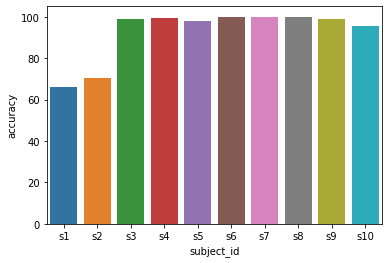

In [18]:
accuracy_df = pd.DataFrame({'subject_id': list(accuracy_dict.keys()), 'accuracy': list(accuracy_dict.values())})
sns.barplot(data=accuracy_df, x='subject_id', y='accuracy');